# Sentiment Analysis

## Contents:
* 1. Dataset
    * 1.1. Loading Data
    * 1.2. Data Preprocessing
    * 1.3. Dataset Visualization
    * 1.4. Vectorization
* 2. Classifiers
    * 2.1. Naive Bayes Classfication
    * 2.2. K-Nearest Neighbour Classification
    * 2.3. Support Vector Machine (SVM) Classification
    * 2.4. Decision Tree Machine Classification
* 3. Training & Evaluation
    * 3.1. Subjectivity
    * 3.2. Polarity
* Advanced. Bert

In [14]:
# A dependency of the preprocessing for BERT inputs
# !pip install -q -U "tensorflow-text==2.8.*"
# !pip install -q tf-models-official==2.7.0
# !pip install wordcloud==1.8.2.2
# !pip install imbalanced_learn==0.9.1
# !pip install imblearn==0.0
# !pip install langdetect==1.0.9
# !pip install regex==2022.3.15

In [2]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import regex as re
import string
import os
import shutil   # for saving the result of BERT training
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory
from imblearn.under_sampling import RandomUnderSampler

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Below are for Bert 

# keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


# set seed for reproducibility
seed=42

## 1. Dataset Presentation

**About DATA:**

This dataset is a mixture of: 
- 

### 1.1. Loading Data
Load necessary data.

In [16]:
# Removing unused columns
df_outside = pd.read_csv('./dataset_transformed.csv', encoding='latin')
df_crawl = pd.read_csv('../input/cz4045tweets/compiled_tweets.csv')

# df_outside = pd.read_csv("/dbfs/FileStore/shared_uploads/dataset_transformed.csv", encoding='latin')
# df_crawl = pd.read_csv("/dbfs/FileStore/shared_uploads/compiled_tweets.csv", encoding='latin')
df_outside = df_outside[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[df_crawl['Subjectivity'].notna()].copy()
df = pd.concat([df_crawl, df_outside]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508 entries, 0 to 13507
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Text          13508 non-null  object 
 1   Subjectivity  11343 non-null  float64
 2   Polarity      7788 non-null   float64
dtypes: float64(2), object(1)
memory usage: 316.7+ KB


### 1.2. Data Preprocessing

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [17]:
# set seed
DetectorFactory.seed = 0

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

In [18]:
df['Language'] = df['Text'].progress_apply(language_detection)

100%|██████████| 13508/13508 [01:18<00:00, 172.97it/s]


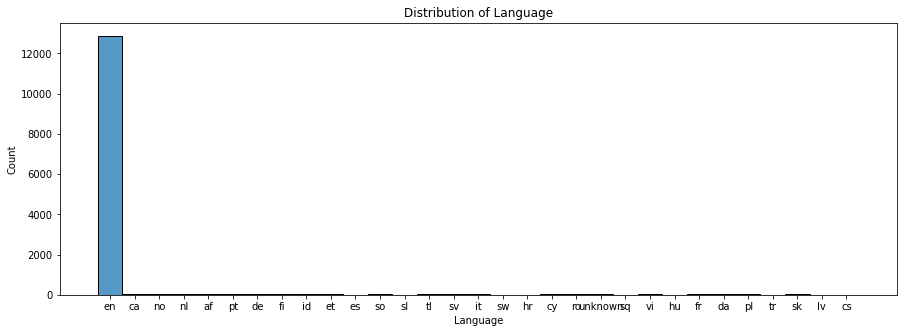

In [19]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df['Language'])
plt.title("Distribution of Language")
plt.show()

In [20]:
df = df[df['Language'] == 'en'].copy()

In [21]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [22]:
df['Text'] = df['Text'].progress_apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

100%|██████████| 12868/12868 [00:00<00:00, 46147.33it/s]


,Text,Subjectivity,Polarity,Language
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en


#### Stemming

In [23]:
nltk.download('punkt')
nltk.download('stopwords')

def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['stemmed_text'] = df['Text'].progress_apply(stem_text)
df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 12868/12868 [00:08<00:00, 1515.74it/s]


,Text,Subjectivity,Polarity,Language,stemmed_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...


#### Lemmatization

In [24]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['lemmatized_text'] = lemmatize_text(df['Text'])
df.head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...


#### Stopwords Removal

In [25]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

In [26]:
df['cleaned_text'] = df['Text'].progress_apply(remove_stopwords)
df['cleaned_stemmed_text'] = df['stemmed_text'].progress_apply(remove_stopwords)
df['cleaned_lemmatized_text'] = df['lemmatized_text'].progress_apply(remove_stopwords)

df.head()

100%|██████████| 12868/12868 [00:02<00:00, 6277.77it/s]


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text,cleaned_text,cleaned_stemmed_text,cleaned_lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...,little bit dbd apex legends co fihcgnia,littl bit dbd apex legend co fihcgnia,little bit dbd apex legend co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...,tuesday night apex lets get damage co dbt givs...,tuesday night apex let get damag co dbt givsyr...,tuesday night apex let get damage co dbt givsy...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...,watch tohrmentgames go crazy apex follow carbo...,watch tohrmentgam go crazi apex follow carbong...,watch tohrmentgames go crazy apex follow carbo...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...,live hopping apexlegends bit come want witness...,live hop apexlegend bit come want wit decent g...,live hopping apexlegends bit come want witness...


### 1.3. Data Visualization

In [27]:
print("========== number of words in the corpus ==========")

print(f"original: {df['Text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {df['stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization: {df['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after removal of stopwords: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming and removal of stopwords: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization and removal of stopwords: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 326258
after stemming: 326653
after lemmatization: 326258
after removal of stopwords: 187578
after stemming and removal of stopwords: 195758
after lemmatization and removal of stopwords: 188188


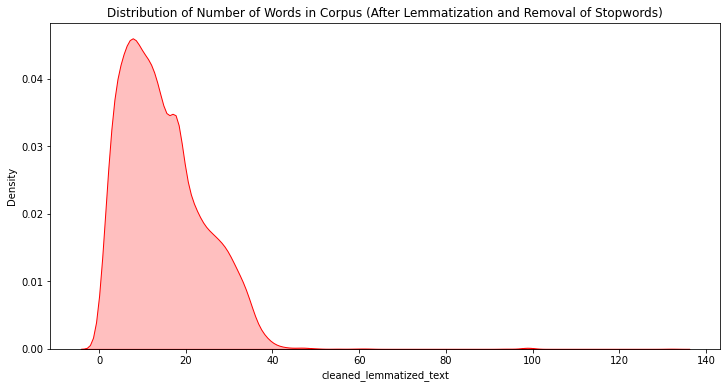

In [28]:
num_words_train = df['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())), fill=True, color="r").set_title('Distribution of Number of Words in Corpus (After Lemmatization and Removal of Stopwords)')

In [29]:
word_list_train = df.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,2640
1,com,1973
2,wa,1170
3,like,1143
4,really,991
5,pic,942
6,get,931
7,one,925
8,time,890
9,co,883


In [30]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = seed,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

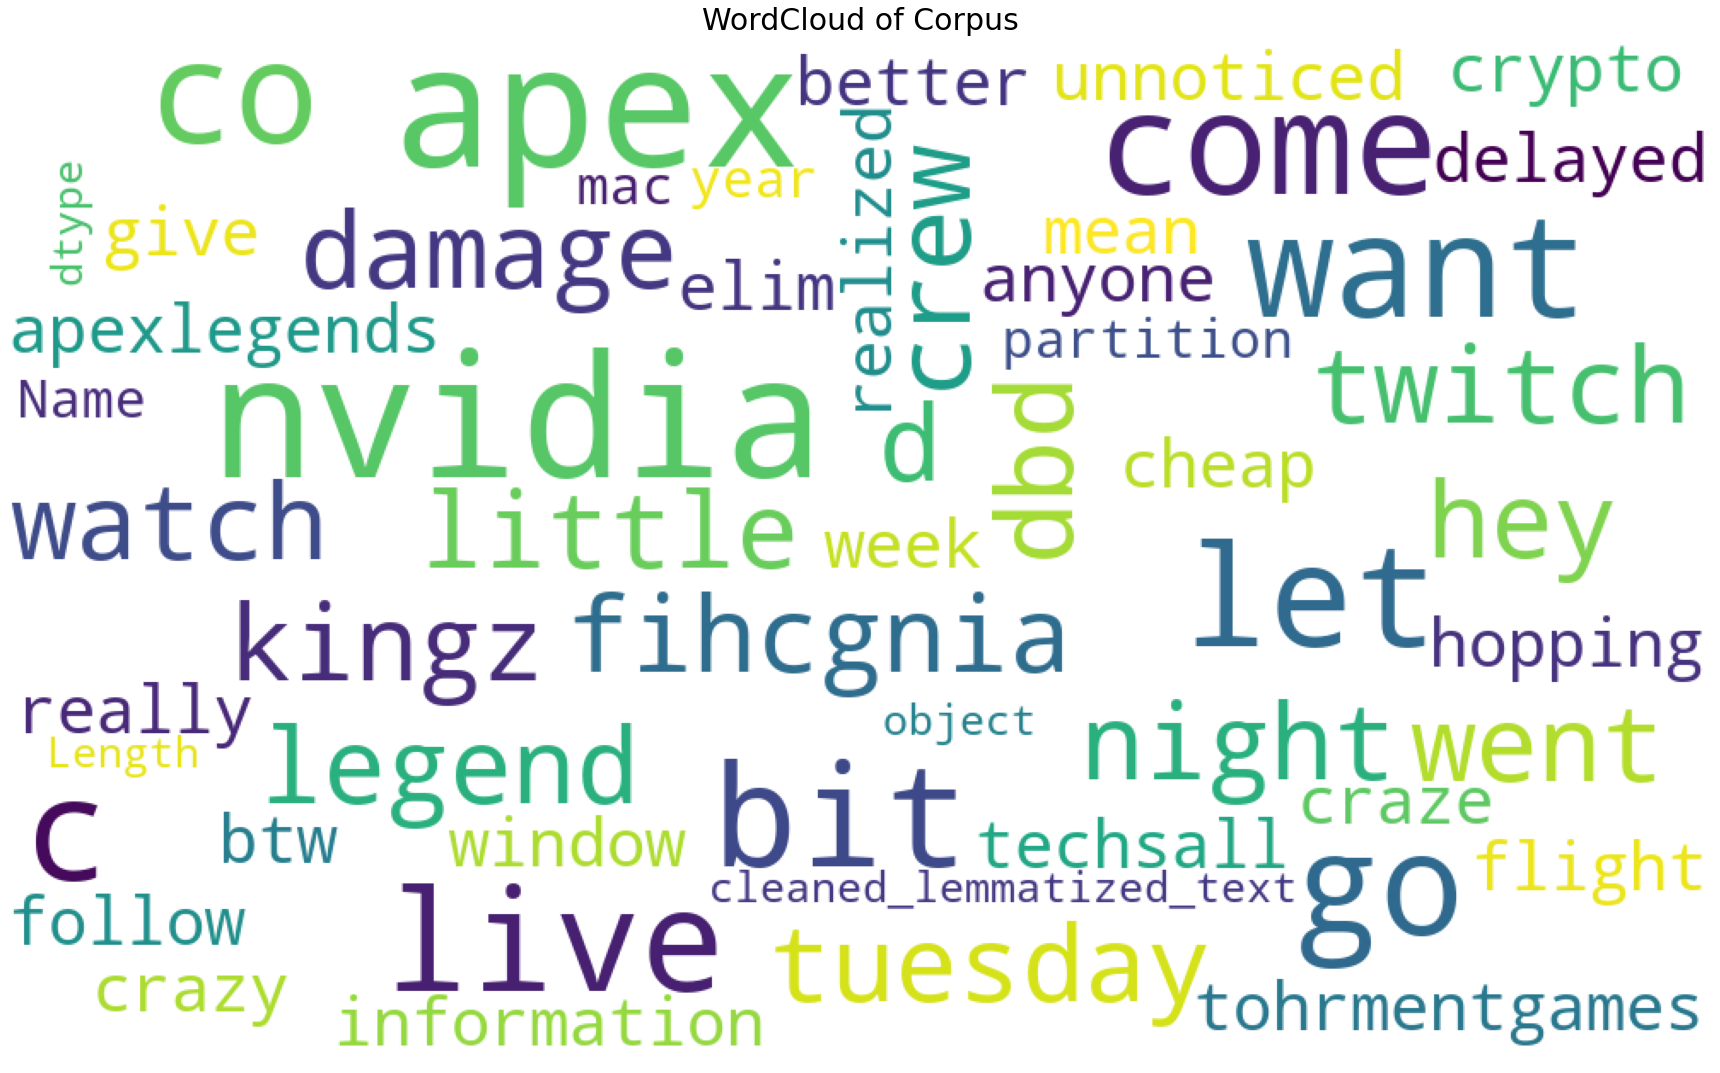

In [31]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

### 1.4. Vectorization

In [32]:
# don't consider uncleaned text for now (too much noise)
preprocessings = ['cleaned_stemmed_text', 'cleaned_lemmatized_text', 'cleaned_text'] 

In [33]:
sub_df = df[df['Subjectivity'].notna()].copy()
sub_df = sub_df.dropna(subset=preprocessings)
sub_df['Subjectivity'].value_counts()

1.0    7387
0.0    3401
Name: Subjectivity, dtype: int64

We can see that here the class is highly unbalanced with too many biased content. For better output, we need to balance the dataset first

In [34]:
#  Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.
sampler = RandomUnderSampler(random_state=seed)
X_sub, Y_sub = sampler.fit_resample(sub_df[preprocessings], sub_df['Subjectivity'])
Y_sub.value_counts()

0.0    3401
1.0    3401
Name: Subjectivity, dtype: int64

In [35]:
# do the same for 'Polarity'
polar_df = df[df['Polarity'].notna()].copy()
polar_df = polar_df.dropna(subset=preprocessings)
polar_df['Polarity'].value_counts()

0.0    3847
1.0    3534
Name: Polarity, dtype: int64

In [36]:
X_polar, Y_polar = sampler.fit_resample(polar_df[preprocessings], polar_df['Polarity'])
Y_polar.value_counts()

0.0    3534
1.0    3534
Name: Polarity, dtype: int64

<b> Train, test, cv split </b>

In [37]:
# for subjectivity, get train set, valid set (cross validation), andn test set
X_train_valid_sub, X_test_sub, y_train_valid_sub, y_test_sub = train_test_split(X_sub, 
                                                    Y_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=Y_sub)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_valid_sub, 
                                                    y_train_valid_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=y_train_valid_sub)

print(f"Shape of X_train: {X_train_sub.shape}")
print(f"Shape of y_train: {y_train_sub.shape}")
print(f"Shape of X_valid: {X_valid_sub.shape}")
print(f"Shape of y_valid: {y_valid_sub.shape}")
print(f"Shape of X_test: {X_test_sub.shape}")
print(f"Shape of y_test: {y_test_sub.shape}")

Shape of X_train: (4352, 3)
Shape of y_train: (4352,)
Shape of X_valid: (1089, 3)
Shape of y_valid: (1089,)
Shape of X_test: (1361, 3)
Shape of y_test: (1361,)


In [38]:
# for polarity, get train set, valid set (cross validation), andn test set
X_train_valid_polar, X_test_polar, y_train_valid_polar, y_test_polar = train_test_split(X_polar, 
                                                    Y_polar,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_polar)
X_train_polar, X_valid_polar, y_train_polar, y_valid_polar = train_test_split(X_train_valid_polar, 
                                                    y_train_valid_polar,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_polar)

print(f"Shape of X_train: {X_train_polar.shape}")
print(f"Shape of y_train: {y_train_polar.shape}")
print(f"Shape of X_valid: {X_valid_polar.shape}")
print(f"Shape of y_valid: {y_valid_polar.shape}")
print(f"Shape of X_test: {X_test_polar.shape}")
print(f"Shape of y_test: {y_test_polar.shape}")

Shape of X_train: (4452, 3)
Shape of y_train: (4452,)
Shape of X_valid: (495, 3)
Shape of y_valid: (495,)
Shape of X_test: (2121, 3)
Shape of y_test: (2121,)


In [39]:
vec_X_train_sub = {}
vec_X_valid_sub = {}
vec_X_test_sub = {}
# The CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 3', it will select the 3 most common words in the data.
for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_sub[method])
    X_train_cv =  clf.transform(X_train_sub[method])
    X_valid_cv = clf.transform(X_valid_sub[method])
    X_test_cv = clf.transform(X_test_sub[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_sub[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_sub[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_sub[method] = tf_transformer.transform(X_test_cv)

In [40]:
vec_X_train_polar = {}
vec_X_valid_polar = {}
vec_X_test_polar = {}

for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_polar[method])
    X_train_cv =  clf.transform(X_train_polar[method])
    X_valid_cv = clf.transform(X_valid_polar[method])
    X_test_cv = clf.transform(X_test_polar[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_polar[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_polar[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_polar[method] = tf_transformer.transform(X_test_cv)

## 2. Classifiers

### 2.1. Naive Bayes Classification

In [41]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(x_train, y_train)
    result = naiveBayes_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

### 2.2. K-Nearest Neighbour (KNN) Classification

In [42]:
def KNNClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        metric = ['euclidean', 'manhattan', 'cosine']
        neighbors = list(range(1,30))
        leaf_size = list(range(1,50))
        weight = ['uniform', 'distance']
        param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
        
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_
    
    
    knn_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], metric= best_params['metric'], leaf_size = best_params['leaf_size'], weights = best_params['weights'])
    knn_model.fit(x_train, y_train)   
    
    result = knn_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", best_params)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
  

### 2.3. Support Vector Machine (SVM) Classification

In [43]:
def SVMClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
        degrees = [0, 1, 2, 3, 4, 5, 6]
        kernels = ['rbf', 'linear', 'poly']
        param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
        
        grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_

    SVM_model = svm.SVC(C = best_params['C'], kernel = best_params['kernel'], gamma = best_params['gamma'], degree = best_params['degree'], random_state=seed)
    SVM_model.fit(x_train, y_train)
    
    result = SVM_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

### 2.4. Decision Tree Classification

In [44]:
def decisionTreeClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):
    
    clf = DecisionTreeClassifier() 

    if best_params is None:
            
        print("Searching for best parameters")
        param_grid = { 
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['sqrt','log2']
        }
        
        grid_search = GridSearchCV(clf, param_grid, cv= 3)
        grid_search.fit(x_valid, y_valid)
        best_params = grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = best_params['criterion'],splitter = best_params['splitter'], max_features = best_params['max_features'], random_state=seed)
    decisionTree_model.fit(x_train, y_train)

    result = decisionTree_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

## 3. Training

### 3.1. Subjectivity Classification & Evaluation 

We use naive bayes model's performance as the baseline for measurements of other models.

In [46]:
best_params_df = pd.read_csv("best_params.csv")

In [47]:
def get_best_params(model_name: str, task: str, src:str):
    param = best_params_df[(best_params_df['model'] == model_name) & (best_params_df['task']==task) & (best_params_df['input'] == src)]['best_params'].values[0]
    try:
        return ast.literal_eval(param)
    except:
        return None

**Best parameters are saved to local file beforehand, allow fast reproduction of results.**    <br>
To disable reading trained parameters, simply delete (or move) the file 'best_params.csv' from notebook's folder

In [48]:
def base_line_performance(processing_idx:int, task: str):
    print("Base line")
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_test = y_test_polar
        
    naiveBayesClassification(x_train, x_test, y_train, y_test, method)

In [49]:
def classifier_performance(processing_idx:int, task: str):
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_valid = vec_X_valid_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_valid = y_valid_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_valid = vec_X_valid_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_valid = y_valid_polar
        y_test = y_test_polar

    decisionTreeClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('DecisionTree', task, method))

    SVMClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('SVM', task, method)
    )

    KNNClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('KNN', task, method)
    )

#### 3.1.1 Subjectivity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



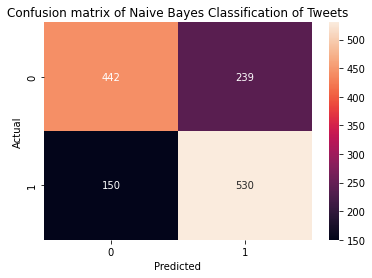

------------ Evaluation Metrics ----------------

F1 score: 0.732
Precision score: 0.689
Recall score: 0.779
Average precision-recall score: 0.647



In [50]:
base_line_performance(0,'subjectivity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



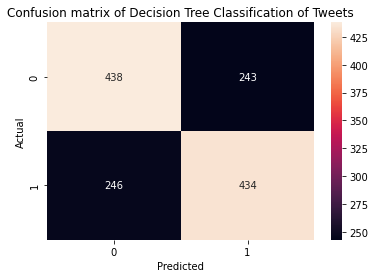

------------ Evaluation Metrics ----------------

F1 score: 0.640
Precision score: 0.641
Recall score: 0.638
Average precision-recall score: 0.590

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 10, 'degree': 2, 'gamma': 0.25, 'kernel': 'poly'}



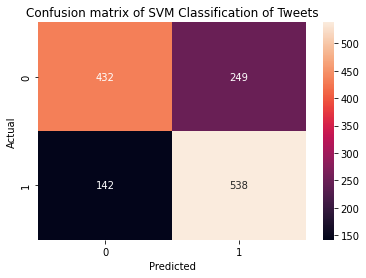

------------ Evaluation Metrics ----------------

F1 score: 0.733
Precision score: 0.684
Recall score: 0.791
Average precision-recall score: 0.645

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 27, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



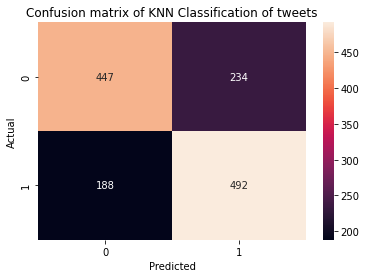

------------ Evaluation Metrics ----------------

F1 score: 0.700
Precision score: 0.678
Recall score: 0.724
Average precision-recall score: 0.628



In [51]:
classifier_performance(0,'subjectivity')

#### 3.1.2 Subjectivity with Cleaned Lemmatized Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



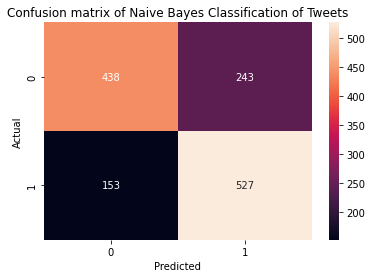

------------ Evaluation Metrics ----------------

F1 score: 0.727
Precision score: 0.684
Recall score: 0.775
Average precision-recall score: 0.643



In [52]:
base_line_performance(1,'subjectivity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



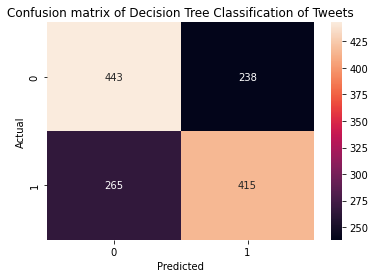

------------ Evaluation Metrics ----------------

F1 score: 0.623
Precision score: 0.636
Recall score: 0.610
Average precision-recall score: 0.583

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.25, 'kernel': 'rbf'}



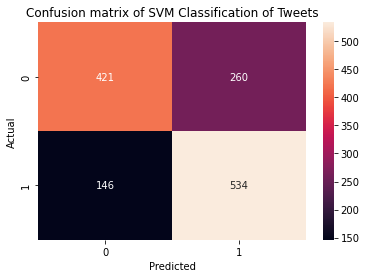

------------ Evaluation Metrics ----------------

F1 score: 0.725
Precision score: 0.673
Recall score: 0.785
Average precision-recall score: 0.635

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 18, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



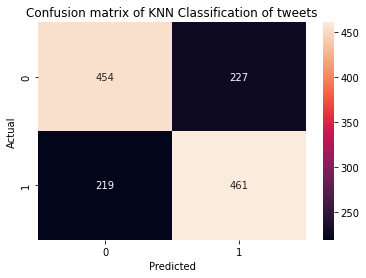

------------ Evaluation Metrics ----------------

F1 score: 0.674
Precision score: 0.670
Recall score: 0.678
Average precision-recall score: 0.615



In [53]:
classifier_performance(1,'subjectivity')

#### 3.1.3 Subjectivity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



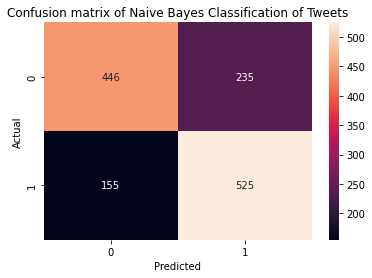

------------ Evaluation Metrics ----------------

F1 score: 0.729
Precision score: 0.691
Recall score: 0.772
Average precision-recall score: 0.647



In [54]:
base_line_performance(2, 'subjectivity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



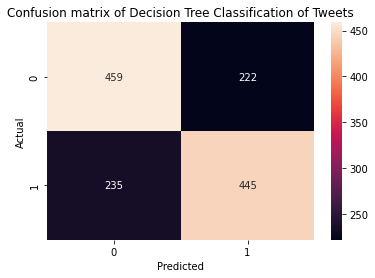

------------ Evaluation Metrics ----------------

F1 score: 0.661
Precision score: 0.667
Recall score: 0.654
Average precision-recall score: 0.609

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.15, 'kernel': 'rbf'}



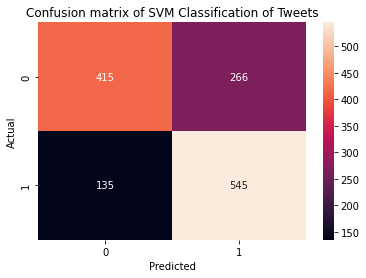

------------ Evaluation Metrics ----------------

F1 score: 0.731
Precision score: 0.672
Recall score: 0.801
Average precision-recall score: 0.638

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 24, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



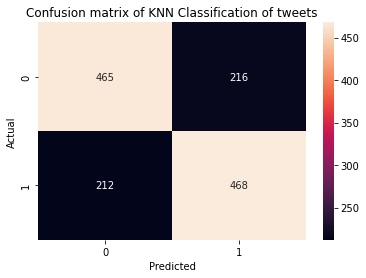

------------ Evaluation Metrics ----------------

F1 score: 0.686
Precision score: 0.684
Recall score: 0.688
Average precision-recall score: 0.627



In [55]:
classifier_performance(2, 'subjectivity')

### 3.2. Polarity Classification & Evaluation 

We use naive bayes model's performance as the baseline for measurements of other models.

#### 3.2.1 Polarity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



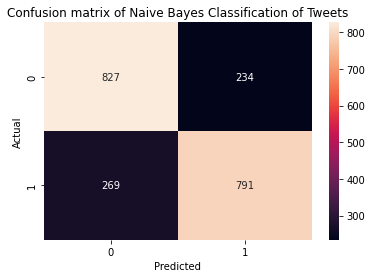

------------ Evaluation Metrics ----------------

F1 score: 0.759
Precision score: 0.772
Recall score: 0.746
Average precision-recall score: 0.703



In [56]:
base_line_performance(0,'polarity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}



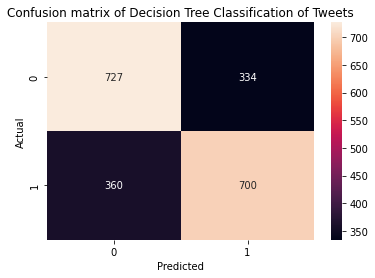

------------ Evaluation Metrics ----------------

F1 score: 0.669
Precision score: 0.677
Recall score: 0.660
Average precision-recall score: 0.617

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



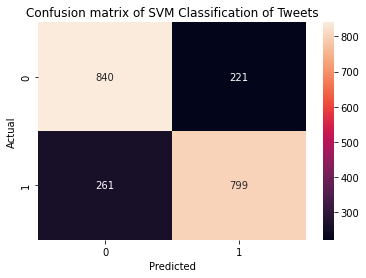

------------ Evaluation Metrics ----------------

F1 score: 0.768
Precision score: 0.783
Recall score: 0.754
Average precision-recall score: 0.714

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 27, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



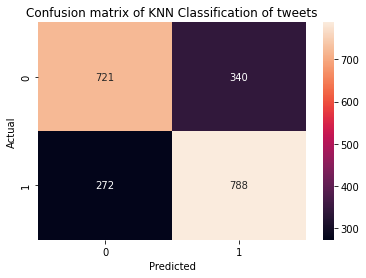

------------ Evaluation Metrics ----------------

F1 score: 0.720
Precision score: 0.699
Recall score: 0.743
Average precision-recall score: 0.648



In [57]:
classifier_performance(0,'polarity')

#### 3.2.2 Polarity with Cleaned Lemmatized Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



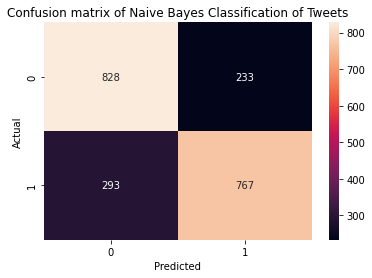

------------ Evaluation Metrics ----------------

F1 score: 0.745
Precision score: 0.767
Recall score: 0.724
Average precision-recall score: 0.693



In [58]:
base_line_performance(1,'polarity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}



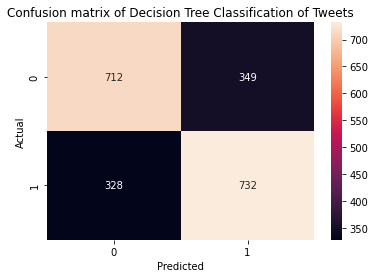

------------ Evaluation Metrics ----------------

F1 score: 0.684
Precision score: 0.677
Recall score: 0.691
Average precision-recall score: 0.622

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 1, 'gamma': 0.25, 'kernel': 'poly'}



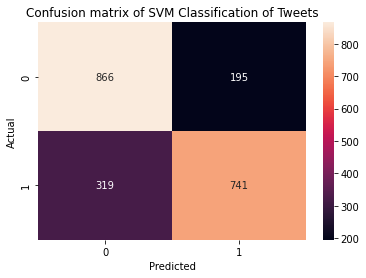

------------ Evaluation Metrics ----------------

F1 score: 0.742
Precision score: 0.792
Recall score: 0.699
Average precision-recall score: 0.704

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



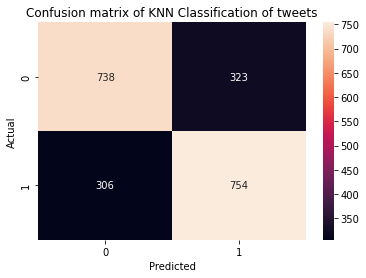

------------ Evaluation Metrics ----------------

F1 score: 0.706
Precision score: 0.700
Recall score: 0.711
Average precision-recall score: 0.642



In [59]:
classifier_performance(1,'polarity')

#### 3.2.3 Polarity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



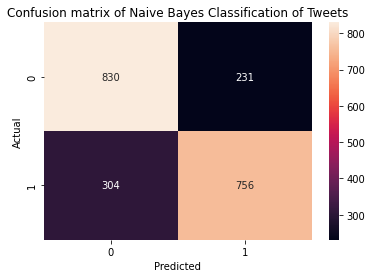

------------ Evaluation Metrics ----------------

F1 score: 0.739
Precision score: 0.766
Recall score: 0.713
Average precision-recall score: 0.690



In [60]:
base_line_performance(2, 'polarity')

Searching for best parameters
Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'best'}



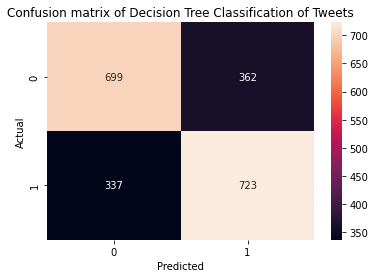

------------ Evaluation Metrics ----------------

F1 score: 0.674
Precision score: 0.666
Recall score: 0.682
Average precision-recall score: 0.613

Searching for best parameters
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.25, 'kernel': 'rbf'}



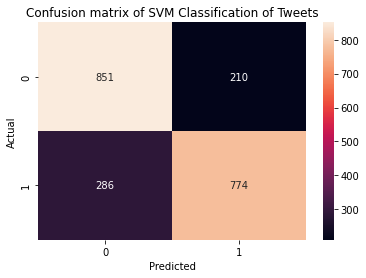

------------ Evaluation Metrics ----------------

F1 score: 0.757
Precision score: 0.787
Recall score: 0.730
Average precision-recall score: 0.709

Searching for best parameters
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 18, 'weights': 'uniform'}
Preprocessing Function:  cleaned_text



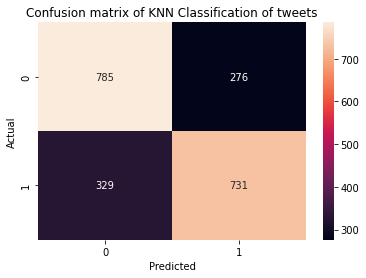

------------ Evaluation Metrics ----------------

F1 score: 0.707
Precision score: 0.726
Recall score: 0.690
Average precision-recall score: 0.656



In [61]:
classifier_performance(2, 'polarity')

## Innovation: Traditionoal Classifiers vs Bert

Reference:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert#evaluate_the_model

In [63]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [115]:
def plot_training_epoch(history, acc_label='binary_accuracy', acc_val_label='val_binary_accuracy', loss_label='loss', loss_val_label='val_loss'):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict[acc_label]
    val_acc = history_dict[acc_val_label]
    loss = history_dict[loss_label]
    val_loss = history_dict[loss_val_label]

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [95]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(5,5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()
    print('\tClassification Report for BERT:\n\n',classification_report(y, y_pred, target_names=labels))

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Raw Model 

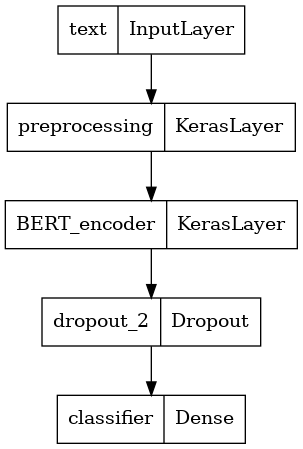

In [97]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [98]:
bert_raw_result = classifier_model(np.array(X_test_sub['cleaned_text']))

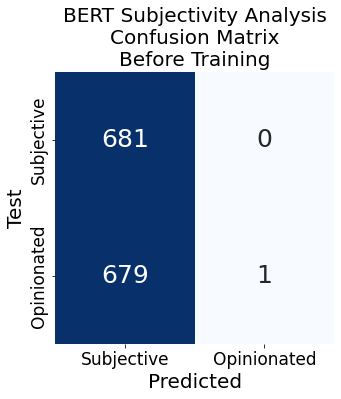

	Classification Report for BERT:

               precision    recall  f1-score   support

  Subjective       0.50      1.00      0.67       681
 Opinionated       1.00      0.00      0.00       680

    accuracy                           0.50      1361
   macro avg       0.75      0.50      0.34      1361
weighted avg       0.75      0.50      0.34      1361



In [99]:
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(bert_raw_result)),'BERT Subjectivity Analysis\nConfusion Matrix\nBefore Training', ['Subjective', 'Opinionated'])

### Training Model for Subjectivity

In [137]:
def get_optimizer(steps_per_epoch, epochs=5, batch_size=32, init_lr = 3e-5):
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    return optimization.create_optimizer(init_lr=init_lr,num_train_steps=num_train_steps,num_warmup_steps=num_warmup_steps,optimizer_type='adamw')

In [ ]:
sub_model = build_classifier_model()

sub_model.compile(optimizer=get_optimizer(epochs=10,steps_per_epoch=len(X_train_sub['cleaned_text'])/batch_size),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy())

print(f'Training model with {tfhub_handle_encoder}')

history = sub_model.fit(np.array(X_train_sub['cleaned_text']), y_train_sub, 
                               validation_data=(np.array(X_valid_sub['cleaned_text']), y_valid_sub), 
                               epochs=10, batch_size=batch_size)  # Pass callback to training

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
136/136 [==============================] - 32s 193ms/step - loss: 0.6800 - binary_accuracy: 0.5772 - val_loss: 0.6022 - val_binary_accuracy: 0.6602
Epoch 2/10
136/136 [==============================] - 26s 189ms/step - loss: 0.5882 - binary_accuracy: 0.6579 - val_loss: 0.5690 - val_binary_accuracy: 0.6933
Epoch 3/10
136/136 [==============================] - 26s 189ms/step - loss: 0.5168 - binary_accuracy: 0.7330 - val_loss: 0.5727 - val_binary_accuracy: 0.6878
Epoch 4/10
136/136 [==============================] - 26s 188ms/step - loss: 0.4551 - binary_accuracy: 0.7723 - val_loss: 0.5920 - val_binary_accuracy: 0.7016
Epoch 5/10
136/136 [==============================] - 26s 190ms/step - loss: 0.3796 - binary_accuracy: 0.8208 - val_loss: 0.6010 - val_binary_accuracy: 0.7117
Epoch 6/10
136/136 [==============================] - 26s 189ms/step - loss: 0.3198 - binary_accuracy: 0.8536 - v

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


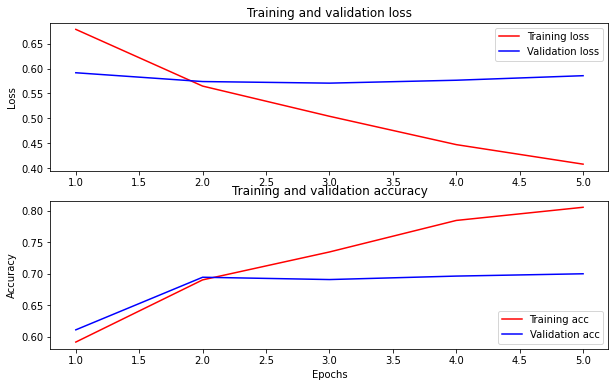

In [124]:
plot_training_epoch(history)

In [127]:
loss, accuracy = sub_model.evaluate(np.array(X_test_sub['cleaned_text']), y_test_sub)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

43/43 [==============================] - 4s 97ms/step - loss: 0.6248 - binary_accuracy: 0.6914
Loss: 0.6248292922973633
Accuracy: 0.6914033889770508


In [128]:
y_pred_sub = sub_model.predict(np.array(X_test_sub['cleaned_text']))

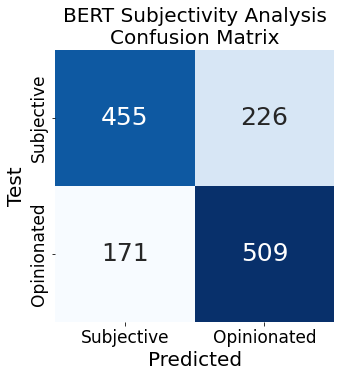

	Classification Report for BERT:

               precision    recall  f1-score   support

  Subjective       0.73      0.67      0.70       681
 Opinionated       0.69      0.75      0.72       680

    accuracy                           0.71      1361
   macro avg       0.71      0.71      0.71      1361
weighted avg       0.71      0.71      0.71      1361



In [129]:
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(y_pred_sub)),'BERT Subjectivity Analysis\nConfusion Matrix', ['Subjective', 'Opinionated'])

In [154]:
# import shutil
shutil.rmtree('./bert_subjectivity_model')
os.remove('bert_subjectivity_model.zip')

In [155]:
# save the model for future use
sub_model.save('./bert_subjectivity_model', include_optimizer=False)
shutil.make_archive('bert_subjectivity_model', 'zip', './bert_subjectivity_model')

'/kaggle/working/bert_subjectivity_model.zip'

### Train Model for Polarity

We are going to use Binary Cross Entropy loss function

In [157]:
polar_model = build_classifier_model()

polar_model.compile(optimizer=get_optimizer(epochs=10,steps_per_epoch=len(X_train_polar['cleaned_text'])/batch_size),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy())

print(f'Training model with {tfhub_handle_encoder}')

polar_history = polar_model.fit(np.array(X_train_polar['cleaned_text']), y_train_polar, 
                               validation_data=(np.array(X_valid_polar['cleaned_text']), y_valid_polar), 
                               epochs=10, batch_size=batch_size)  # Pass callback to training

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
140/140 [==============================] - 31s 178ms/step - loss: 0.6000 - binary_accuracy: 0.6575 - val_loss: 0.4713 - val_binary_accuracy: 0.7919
Epoch 2/10
140/140 [==============================] - 25s 175ms/step - loss: 0.4270 - binary_accuracy: 0.7990 - val_loss: 0.4854 - val_binary_accuracy: 0.7616
Epoch 3/10
140/140 [==============================] - 24s 174ms/step - loss: 0.3499 - binary_accuracy: 0.8403 - val_loss: 0.4455 - val_binary_accuracy: 0.8020
Epoch 4/10
140/140 [==============================] - 25s 175ms/step - loss: 0.2800 - binary_accuracy: 0.8794 - val_loss: 0.4939 - val_binary_accuracy: 0.8000
Epoch 5/10
140/140 [==============================] - 24s 173ms/step - loss: 0.2137 - binary_accuracy: 0.9043 - val_loss: 0.5627 - val_binary_accuracy: 0.7879
Epoch 6/10
140/140 [==============================] - 25s 176ms/step - loss: 0.1586 - binary_accuracy: 0.9382 - v

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


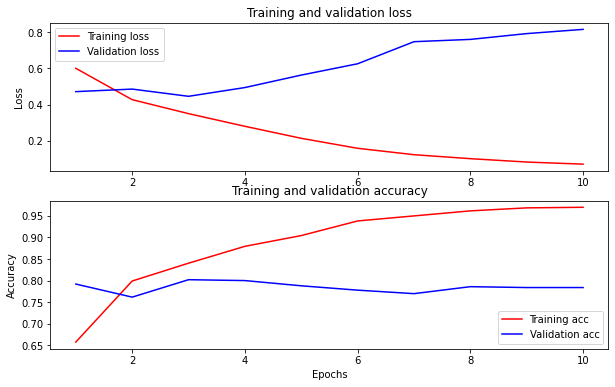

In [158]:
plot_training_epoch(polar_history)

In [159]:
loss, accuracy = polar_model.evaluate(np.array(X_test_polar['cleaned_text']), y_test_polar)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

67/67 [==============================] - 7s 97ms/step - loss: 0.6940 - binary_accuracy: 0.8109
Loss: 0.6939823627471924
Accuracy: 0.8109382390975952


In [160]:
y_pred_polar = polar_model.predict(np.array(X_test_polar['cleaned_text']))

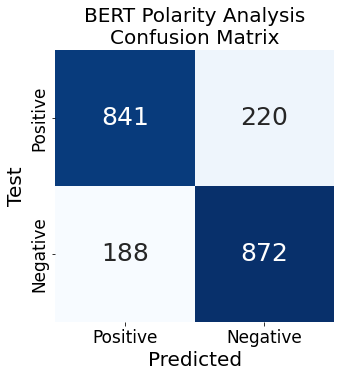

	Classification Report for BERT:

               precision    recall  f1-score   support

    Positive       0.82      0.79      0.80      1061
    Negative       0.80      0.82      0.81      1060

    accuracy                           0.81      2121
   macro avg       0.81      0.81      0.81      2121
weighted avg       0.81      0.81      0.81      2121



In [161]:
conf_matrix(y_test_polar.astype(bool), K.round(tf.sigmoid(y_pred_polar)),'BERT Polarity Analysis\nConfusion Matrix', ['Positive', 'Negative'])

In [162]:
# save the model for future use
polar_model.save('./bert_polarity_model', include_optimizer=False)
shutil.make_archive('bert_polarity_model', 'zip', './bert_polarity_model')

'/kaggle/working/bert_polarity_model.zip'